# Countryrisk

In [1]:
import wbdata
import pandas as pd
import pandas_profiling
import datetime
import quandl
%config IPCompleter.greedy=True
import pandas_datareader
import urllib3


# 1- Extracting and Cleaning the Data from IMF, WB and BIS

## Country selection


In [2]:
### fecthing country names from IMF database to get all ISO codes
countrycodes = pd.read_csv('coucodes.csv', delimiter = ';', encoding = "ISO-8859-1")
countrycodes = countrycodes[["IMF Name", "ISO Code", "ISO2 Code"]]
countrycodes.reset_index(level=0, inplace=True)
countrycodes = countrycodes.rename(columns={'IMF Name': 'country'})

countries = ["Brazil",  "Mexico", "India",  "Russia", "Switzerland", "Uruguay",
             "Korea", "Thailand",  "Bolivia", "Costa Rica", "Colombia", "Paraguay",
             "Chile", "South Africa", "Taiwan", "Turkey", "Ukraine", "Nigeria", "Indonesia",
             "Bangladesh", "Philippines", "Pakistan", "Egypt", "Ethiopia", "Vietnam", "Tanzania",
             "Myanmar", "Algeria", "Sudan", "Uganda", "Morocco", "Uzbekistan", "Malaysia",
             "Afghanistan", "Ghana", "Latvia", "Hong Kong SAR", "Laos", "Singapore", "Poland",
             "Israel", "Czech Republic", "Romania", "New Zealand", "Hungary", "Kazakhstan", "Kenya", "Angola",
             "Ethiopia", "Dominican Republic", "Sri Lanka", "Guatemala", "Bulgaria", "Tanzania", "Belaurus",
            "Croatia", "Uzbekistan", "Syria", "Lebanon", "Slovenia", "Democratic Republic of the Congo",
            "Azerbaijan", "Côte d'Ivoire"]

#Argentina, Australia,  Venezuela e Iraq are not working - Monthly
#
countrycodes = countrycodes[countrycodes["country"].isin(countries)]

In [3]:
from datetime import datetime
from itertools import product

today = datetime.today()
datem = datetime(today.year, today.month, 1)
str(today.month-1) + "-" + str(today.year)

year = pd.date_range('1990-01-01', end = str(today.month-1) + "-" + str(today.year), freq='MS').strftime('%Y-%m')


base = pd.DataFrame(data=list(product(year, countrycodes["ISO2 Code"])), columns=['year','ISO2 Code'])
base = base.sort_values(by=['ISO2 Code', "year"]).dropna()


## WB


In [4]:
#downloading data from worldbank

#from pandas_datareader import wb

#worldbank_data = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_", "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 2010, end = 2020, freq = "M")
#worldbank_data2 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_",  "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1999, end = 2009, freq = "M")
#worldbank_data3 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_","IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1990, end = 1998, freq = "M")

#worldbank_data = pd.concat([worldbank_data, worldbank_data2])
#worldbank_data = pd.concat([worldbank_data, worldbank_data3])

#worldbank_data.reset_index(inplace=True)

#worldbank_data_conc = pd.merge(worldbank_data, countrycodes, on="country")


## IMF

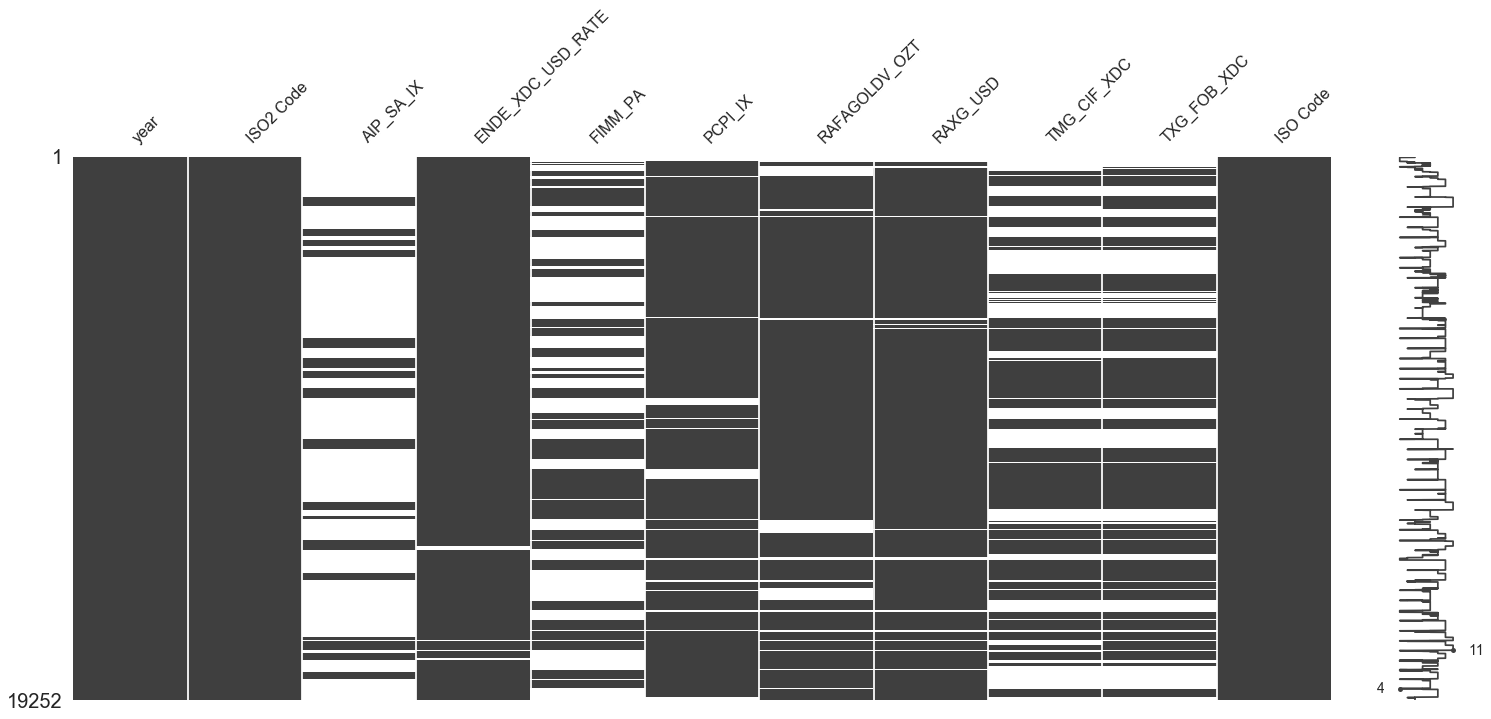

In [5]:
# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/M."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')
#Variables
variables = ".RAFAGOLDV_OZT+RAXG_USD+TXG_FOB_XDC+TMG_CIF_XDC+FIMM_PA+PCPI_IX+ENDE_XDC_USD_RATE+AIP_SA_IX.?startPeriod=1990&endPeriod=2030"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
stack_m = pd.merge(stack, countrycodes[["ISO2 Code", "ISO Code"]], on = "ISO2 Code")
msno.matrix(stack_m)

stack_m = pd.merge(base, stack_m, on = ["ISO2 Code", "year"], how = "left")

In [6]:
#The same for price commodities index


# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/PCTOT/M."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')
#Variables
variables = ".x_gdp.?startPeriod=1990&endPeriod=2030"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.drop(["indicator"], axis = 1)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code", "@OBS_VALUE" : "PCTOT"})
#Next: Analyze the missing data and data range

stack_m2 = stack.drop_duplicates(["year", "ISO2 Code"])

stack_m3 = pd.merge(stack_m, stack_m2, on = ["ISO2 Code", "year"], how = "left")

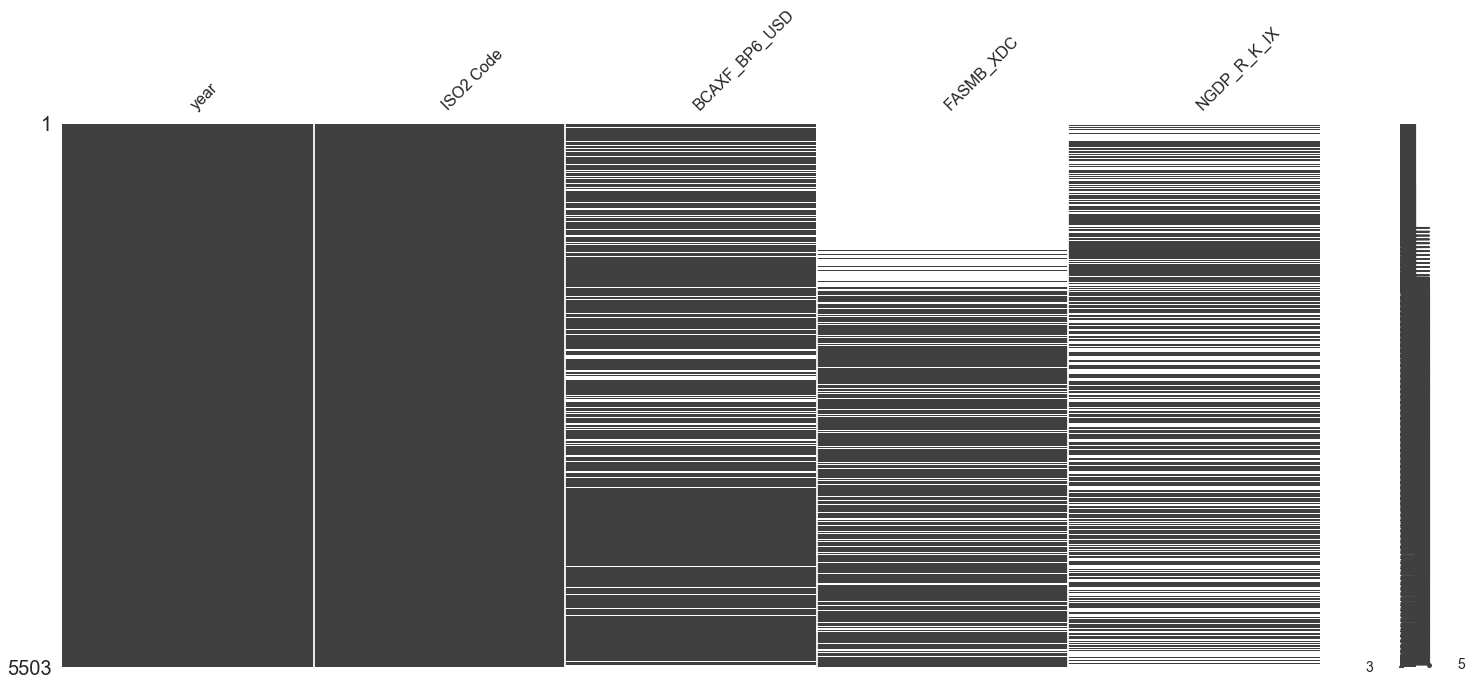

In [7]:
#Quarterly data


import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')

#Variables
variables = ".NGDP_R_K_IX+PCTOT+BCAXF_BP6_USD+FASMB_XDC.?startPeriod=1990&endPeriod=2020"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
msno.matrix(stack)
stack_q = pd.merge(stack, countrycodes[["ISO2 Code"]], on = "ISO2 Code")


In [8]:
# merging monthly and quarterly

stack_q["year"] = pd.to_datetime(stack_q["year"])
stack_m3["year"] = pd.to_datetime(stack_m3["year"])

stack = pd.merge(stack_m3, stack_q, on = ["year", "ISO2 Code"], how = "left")

## OECD

In [9]:
from cif import cif

data_all, subjects_all, measures_all = cif.createDataFrameFromOECD(countries = countrycodes["ISO Code"].tolist(), frequency = 'M', subject = ["SPASTT01"])


C:\Users\vitor\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/AFG.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/DZA.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/AGO.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/AZE.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BGD.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BOL.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BRA.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/BRA.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BGR.SPASTT01..M/all


C:\Users\vitor\Anaconda3\lib\site-packages\cif\cif.py:248: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = [np.repeat(0, dataPart.shape[1]), dataPart.columns.labels[0], dataPart.columns.labels[1]],
C:\Users\vitor\Anaconda3\lib\site-packages\cif\cif.py:249: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  names = ['country', dataPart.columns.names[0], dataPart.columns.names[1]])


Error: No available records, please change parameters
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CHL.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/CHL.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/COL.SPASTT01..M/all


C:\Users\vitor\Anaconda3\lib\site-packages\cif\cif.py:251: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  dataAll = pd.concat([dataAll, dataPart], axis = 1)


Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/COL.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/COD.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CRI.SPASTT01..M/all
Error: No available records, please change parameters
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/HRV.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CZE.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/CZE.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/DOM.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/EGY.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/ETH.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/GHA.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd

In [10]:
oecd = data_all.stack(level = 0)
oecd.columns = oecd.columns.droplevel(0)
oecd = oecd.reset_index()
oecd = oecd.drop(['GP', 'GY'], axis=1)  
oecd["level_0"] = pd.to_datetime(oecd["level_0"])


In [11]:
oecd

measure,level_0,country,IXOB
0,1955-01-01,CHE,2.879581
1,1955-02-01,CHE,2.858126
2,1955-03-01,CHE,2.902376
3,1955-04-01,CHE,2.853433
4,1955-05-01,CHE,2.820581
...,...,...,...
8089,2019-10-01,POL,109.530624
8090,2019-10-01,RUS,164.669118
8091,2019-10-01,SVN,116.083944
8092,2019-10-01,TUR,123.143367


In [12]:
full = pd.merge(stack, oecd, left_on = ["ISO Code", "year"], right_on = ["country", "level_0"], how = "left")


## BIS

In [13]:
from io import BytesIO
import pandas as pd
from urllib.request import urlopen
from zipfile import ZipFile

z = urlopen('https://www.bis.org/statistics/full_bis_total_credit_csv.zip')
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_TOTAL_CREDIT_DATAFLOW_csv_col.csv')
credit =pd.read_csv(myzip)


credit = credit[(credit["Borrowing sector"] == "Private non-financial sector") | (credit["Borrowing sector"] == "General government")]
credit = credit[(credit["Lending sector"] == "All sectors")]
credit = credit[(credit["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
credit = credit[(credit["Unit type"] == "Percentage of GDP")]
credit = credit[(credit["TC_ADJUST"] == "A")]
credit = credit[(credit["Valuation"] == "Market value")]
credit = (credit.set_index(['Borrowing sector', 'BORROWERS_CTY'])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack('Borrowing sector')
   .reset_index())
credit = credit.iloc[13:]

In [14]:
z = urlopen('https://www.bis.org/statistics/full_bis_dsr_csv.zip')
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_DSR_DATAFLOW_csv_col.csv')
debt_service =pd.read_csv(myzip)

debt_service = debt_service[(debt_service["Borrowers"] == "Private non-financial sector")]
debt_service = debt_service[(debt_service["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
debt_service = (debt_service.set_index(['BORROWERS_CTY', "Borrowers"])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack("Borrowers")
   .reset_index())

debt_service = debt_service.iloc[5:]
debt_service.columns = debt_service.columns = ["BORROWERS_CTY", "Year", "debt_service"]

In [15]:
from bs4 import BeautifulSoup, SoupStrainer
import requests
import re

url = "https://oefdatascience.github.io/REIGN.github.io/menu/reign_current.html"

page = requests.get(url)    
data = page.text
soup = BeautifulSoup(data)

links = []
for link in soup.find_all(attrs={'href': re.compile("http")}):
    links.append(link.get('href'))


sub = "https://cdn.rawgit.com/OEFDataScience/REIGN.github.io/gh-pages/data_sets/REIGN"


link = [word for word in links if word.startswith(sub)]

import pandas as pd
couprisk = pd.read_csv(link[0])
couprisk = couprisk[["country", "year", "month", "couprisk"]]
couprisk["month"] = couprisk["month"].astype(int)
couprisk["month"] = couprisk.month.map("{:02}".format)
couprisk["year"] = couprisk["year"].round().astype(int).astype(str) + "-" + couprisk["month"].astype(str)+"-" + "01"



In [16]:
couprisk = couprisk[couprisk["country"].isin(countries)]
couprisk = pd.merge(couprisk, countrycodes, on = "country")
couprisk = couprisk.drop(["index", "ISO Code"], 1)
couprisk = couprisk.drop_duplicates(["year", "country"])

In [17]:
credit["Year"] = pd.to_datetime(credit["Year"], errors = "coerce")
debt_service["Year"] = pd.to_datetime(debt_service["Year"], errors = "coerce")
couprisk["year"] = pd.to_datetime(couprisk["year"], errors = "coerce")


full = pd.merge(full, credit, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, debt_service, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, couprisk, on = ["ISO2 Code", "year"], how = "left")


In [18]:
full[full["year"] == "2019-10-01"]

,year,ISO2 Code,AIP_SA_IX,ENDE_XDC_USD_RATE,FIMM_PA,PCPI_IX,RAFAGOLDV_OZT,RAXG_USD,TMG_CIF_XDC,TXG_FOB_XDC,...,BORROWERS_CTY_x,Year_x,General government,Private non-financial sector,BORROWERS_CTY_y,Year_y,debt_service,country_y,month,couprisk
357,2019-10-01,AF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,10,0.000514
715,2019-10-01,AO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Angola,10,0.001235
1073,2019-10-01,AZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Azerbaijan,10,0.000453
1431,2019-10-01,BD,NaN,84.75,NaN,NaN,0.44914346,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Bangladesh,10,0.000649
1789,2019-10-01,BG,NaN,1.7535,-0.5235,NaN,1.3015,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Bulgaria,10,0.001891
2147,2019-10-01,BO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Bolivia,10,0.003492
2505,2019-10-01,BR,NaN,4.0035,NaN,NaN,2.16577976,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Brazil,10,0.000465
2863,2019-10-01,CD,NaN,1654.3993,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3221,2019-10-01,CH,NaN,0.98745,NaN,99.3181295040891,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Switzerland,10,0.000268
3579,2019-10-01,CL,NaN,726.34,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Chile,10,0.000501


# 2 - Creating variables and cleaning the Data

In [19]:
#droping duplicated columns
full = full.drop(columns = ["country_x", "Year_x","country_y", "Year_y", "BORROWERS_CTY_x", "BORROWERS_CTY_y", "Year_y","level_0"])


In [20]:
#to numeric
cols = full.columns.drop(["ISO2 Code", "year"])

full[cols] = full[cols].apply(pd.to_numeric, errors='coerce')

In [83]:
#creating variable

iso = full["ISO2 Code"]

full = full.groupby('ISO2 Code').ffill()

full["ISO2 Code"] = iso

full["gdp_growth"] = full.groupby('ISO2 Code', sort=False).NGDP_R_K_IX.apply(
     lambda x: x.pct_change(12))

full.rename(columns={'Private non-financial sector':'credit_private', 'General government': 'credit_government'}, inplace=True)

full["credit_growth"] = full.groupby('ISO2 Code', sort=False).credit_private.apply(
     lambda x: x.pct_change(12))

full["inflation"] = full.groupby('ISO2 Code', sort=False).PCPI_IX.apply(
     lambda x: x.pct_change(12))

full["stock_growth"]  = full.groupby('ISO2 Code', sort=False).IXOB.apply(
     lambda x: x.pct_change(1))


full["exchange_change"] = full.groupby('ISO2 Code', sort=False).ENDE_XDC_USD_RATE.apply(
     lambda x: x.pct_change(1))

full["exchange_12a"] = full.groupby('ISO2 Code', sort=False).ENDE_XDC_USD_RATE.apply(
     lambda x: x.pct_change(12))

full["industrial_growth"] = full.groupby('ISO2 Code', sort=False).AIP_SA_IX.apply(
     lambda x: x.pct_change(1))

full["commodities_growth"] = full.groupby('ISO2 Code', sort=False).PCTOT.apply(
     lambda x: x.pct_change(12))

full["reserves_gdp"] = full["RAXG_USD"]/full["NGDP_R_K_IX"]

full["imports_gdp"] = full["TMG_CIF_XDC"]/full["NGDP_R_K_IX"]

full["exports_gdp"] = full["TXG_FOB_XDC"]/full["NGDP_R_K_IX"]


In [84]:
#Counting missing values by country
full2 = full
g = full2.groupby('ISO2 Code')
g.count().rsub(g.size(), axis=0).to_csv("missings.csv")

In [85]:
#Dropping columns used to create the new variables
#Scaling

full3 = full2.drop(["ISO Code", "FASMB_XDC", "credit_government", "RAFAGOLDV_OZT",  "TXG_FOB_XDC", "TMG_CIF_XDC", "RAXG_USD", "PCTOT", "AIP_SA_IX", "ENDE_XDC_USD_RATE", "PCPI_IX", "IXOB"], 1 )
#full3 = full3.groupby('ISO2 Code').transform(lambda x: (x - x.mean()) / x.std())
full3["ISO2 Code"] = full2["ISO2 Code"]
full3["year"] = full2["year"]
full3["year2"] = full3["year"].dt.strftime('%Y%m%d').astype(float)
full3 = pd.get_dummies(full3, columns=['ISO2 Code'], prefix = ['Country'])
full3 = full3.set_index("year")
from numpy import inf

full3[full3 == inf] = 0 

In [86]:
full3

,FIMM_PA,BCAXF_BP6_USD,NGDP_R_K_IX,credit_private,debt_service,month,couprisk,gdp_growth,credit_growth,inflation,...,Country_SY,Country_TH,Country_TR,Country_TZ,Country_UA,Country_UG,Country_UY,Country_UZ,Country_VN,Country_ZA
year,,,,,,,,,,,,,,,,,,,,,
1990-01-01,NaN,NaN,NaN,NaN,NaN,1.0,0.006598,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1990-02-01,NaN,NaN,NaN,NaN,NaN,2.0,0.007205,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1990-03-01,NaN,NaN,NaN,NaN,NaN,3.0,0.006140,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1990-04-01,NaN,NaN,NaN,NaN,NaN,4.0,0.008673,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1990-05-01,NaN,NaN,NaN,NaN,NaN,5.0,0.008243,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-01,6.74,-2028.787053,100.499418,74.8,9.2,6.0,0.000785,0.0,0.043236,0.044734,...,0,0,0,0,0,0,0,0,0,1
2019-07-01,6.64,-2028.787053,100.499418,74.8,9.2,7.0,0.000834,0.0,0.028886,0.039741,...,0,0,0,0,0,0,0,0,0,1
2019-08-01,6.49,-2028.787053,100.499418,74.8,9.2,8.0,0.000857,0.0,0.028886,0.043478,...,0,0,0,0,0,0,0,0,0,1


In [87]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(full3)
full4 = pd.DataFrame(scaler.transform(full3), columns=full3.columns, index = full3.index)


In [88]:
#from missingpy import MissForest
#imputer = MissForest()
#X_filled_knn = imputer.fit_transform(full3)

In [89]:
#Imputing missing data with KNN

from fancyimpute import IterativeImputer, IterativeSVD, MatrixFactorization,NuclearNormMinimization, BiScaler, KNN, SoftImpute

X_filled_knn = KNN().fit_transform(full4)


Imputing row 1/19690 with 16 missing, elapsed time: 224.578
Imputing row 101/19690 with 13 missing, elapsed time: 225.233
Imputing row 201/19690 with 12 missing, elapsed time: 225.711
Imputing row 301/19690 with 10 missing, elapsed time: 226.173
Imputing row 401/19690 with 12 missing, elapsed time: 226.369
Imputing row 501/19690 with 12 missing, elapsed time: 226.581
Imputing row 601/19690 with 11 missing, elapsed time: 226.788
Imputing row 701/19690 with 10 missing, elapsed time: 226.988
Imputing row 801/19690 with 12 missing, elapsed time: 227.218
Imputing row 901/19690 with 11 missing, elapsed time: 227.429
Imputing row 1001/19690 with 11 missing, elapsed time: 227.633
Imputing row 1101/19690 with 12 missing, elapsed time: 227.858
Imputing row 1201/19690 with 10 missing, elapsed time: 228.065
Imputing row 1301/19690 with 10 missing, elapsed time: 228.285
Imputing row 1401/19690 with 10 missing, elapsed time: 228.472
Imputing row 1501/19690 with 6 missing, elapsed time: 228.761
Imput

Imputing row 13101/19690 with 3 missing, elapsed time: 304.673
Imputing row 13201/19690 with 3 missing, elapsed time: 304.985
Imputing row 13301/19690 with 5 missing, elapsed time: 305.285
Imputing row 13401/19690 with 5 missing, elapsed time: 305.635
Imputing row 13501/19690 with 5 missing, elapsed time: 305.937
Imputing row 13601/19690 with 5 missing, elapsed time: 307.295
Imputing row 13701/19690 with 10 missing, elapsed time: 308.843
Imputing row 13801/19690 with 10 missing, elapsed time: 309.188
Imputing row 13901/19690 with 10 missing, elapsed time: 309.574
Imputing row 14001/19690 with 8 missing, elapsed time: 309.956
Imputing row 14101/19690 with 0 missing, elapsed time: 310.191
Imputing row 14201/19690 with 0 missing, elapsed time: 310.191
Imputing row 14301/19690 with 0 missing, elapsed time: 310.192
Imputing row 14401/19690 with 8 missing, elapsed time: 310.509
Imputing row 14501/19690 with 7 missing, elapsed time: 310.875
Imputing row 14601/19690 with 6 missing, elapsed tim

In [90]:
full_fill = pd.DataFrame(data=X_filled_knn, columns=full3.columns, index = full3.index)
full2 = full2.set_index("year")
full_fill["ISO2 Code"] = full2["ISO2 Code"]
full_fill["exchange_change"] = full2["exchange_change"]
full_fill["exchange_12a"] = full2["exchange_12a"]

In [91]:
import statsmodels.api as sm

### Creating FX gap variable

groups = full_fill.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['exchange_change']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=400000)

    g['fx_gap'] = trend
    bs = bs.append(g)

full_fill = bs

In [92]:
### Creating credit gap variable
groups = full_fill.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs2 = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['credit_private']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=400000)

    g['credit_gap'] = trend
    bs2 = bs2.append(g)

full_fill = bs2

# Definition of dependent variable

In [93]:
import numpy as np

#FIRST DEFINITION
full_fill["dummy"] = np.where(full_fill['exchange_change'] >0.15, 1, 0) #20 percent variation

#SECOND DEFINITION
#full_fill["threshold"] = full_fill.groupby("ISO2 Code")["exchange_change"].transform("mean") + 3*(full_fill.groupby("ISO2 Code")["exchange_change"].transform("std"))
#full_fill["dummy"] = np.where(full_fill['exchange_change'] > full_fill["threshold"], 1, 0) # > 2 stdev threshold

#THIRD DEFINITION
#full_fill["dummy"] = np.where(full_fill['exchange_12a'].shift(-12) >0.3, 1, 0) #50 percent variation in the next 12 months


crise = full_fill

crise["lag_1"] =crise.groupby("ISO2 Code")["dummy"].shift(-1)
crise["lag_2"] =crise.groupby("ISO2 Code")["dummy"].shift(-2)
crise["lag_3"] =crise.groupby("ISO2 Code")["dummy"].shift(-3)
crise["lag_4"] =crise.groupby("ISO2 Code")["dummy"].shift(-4)
crise["lag_5"] =crise.groupby("ISO2 Code")["dummy"].shift(-5)
crise["lag_6"] =crise.groupby("ISO2 Code")["dummy"].shift(-6)
crise["lag_7"] =crise.groupby("ISO2 Code")["dummy"].shift(-7)
crise["lag_8"] =crise.groupby("ISO2 Code")["dummy"].shift(-8)
crise["lag_9"] =crise.groupby("ISO2 Code")["dummy"].shift(-9)
crise["lag_10"] =crise.groupby("ISO2 Code")["dummy"].shift(-10)
crise["lag_11"] =crise.groupby("ISO2 Code")["dummy"].shift(-11)
crise["lag_12"] =crise.groupby("ISO2 Code")["dummy"].shift(-12)
#crise["yt-1"] =crise.groupby("ISO2 Code")["dummy"].shift(0)
#crise["yt2-1"] = crise["exchange_change"].shift(-1)
crise.fillna(0, inplace=True)


In [94]:
bs2['indicator'] =  bs2["lag_1"] + bs2["lag_2"] + bs2["lag_3"] + bs2["lag_4"] + bs2["lag_5"] + bs2["lag_6"] + bs2["lag_7"] + bs2["lag_8"] + bs2["lag_9"] + bs2["lag_10"] + bs2["lag_11"] +bs2["lag_12"]
bs2['indicator2'] = np.where(bs2['indicator'] > 0, 1, 0)

#bs2['indicator2'] = crise["dummy"] #Third Definition

#bs2["lag_1"] +
#bs2['indicator'] = bs2["lag_1"] +bs2["lag_2"]  + bs2["lag_3"] + bs2["lag_4"] + bs2["lag_5"] +bs2["lag_6"]
#bs2['indicator2'] = np.where(bs2['indicator'] > 0, 1, 0)

In [95]:
full_fill = bs2

In [96]:
### Preparing machine learning pipeline 

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier

In [97]:
columns = full_fill.columns
columns = columns.drop(["NGDP_R_K_IX", "credit_private", "year2", "dummy", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "indicator", "indicator2", "fx_gap", "exchange_change", "month"])

# K- Fold


In [ ]:
full_fill2 = full_fill.loc["1990-01-01":"2017-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2]
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = X.drop(["ISO2 Code"], axis =1)

In [ ]:
X

In [269]:
### train test split

X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=full_fill2['indicator2'])

In [270]:
# Spot-Check Algorithms
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    basedModels.append(('XGB'   , XGBClassifier()))


    
    return basedModels

In [271]:
from sklearn.metrics import confusion_matrix


def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'roc_auc'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state= 1990)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [272]:
from plotly import graph_objs as go
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [273]:
from plotly import graph_objs as go

In [274]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.786560 (0.018113)
LDA: 0.778459 (0.019717)


KeyboardInterrupt: 

In [ ]:
model =  ExtraTreesClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(y_test, y_pred)



In [ ]:
### feature importance

clf = ExtraTreesClassifier(random_state= 1984)

clf.fit(X_train, y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(100,150))
plt.show()

In [ ]:
X_test["pred"] = y_prob
X_test2 = X_test[X_test["Country_BR"] > 0]
X_test2['pred'].plot(linewidth=5, figsize=(15,15))


# Time-Test

In [ ]:
full_fill2 = full_fill.loc["1990-01-01":"2017-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2]
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)

X = X.drop(["ISO2 Code"], axis =1)

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2017-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2017-12-31"]



In [ ]:
models = GetBasedModel()
names,results = BasedLine2(X_train, Y_train,models)
PlotBoxR().PlotResult(names,results)

In [ ]:

model =  XGBClassifier()
model= MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
#confusion_matrix(Y_test, y_pred)

In [ ]:
from matplotlib import cm

X_test["pred"] = y_prob
X_test["dummy"] = Y_test
X_test2 = X_test[X_test["Country_RU"] > 0]
X_test2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))


In [ ]:
a = full[full["exchange_change"] > 0.1]
a = a[a["year"]> "2010-01-01"]
a["ISO2 Code"]

In [ ]:
X_test2["dummy"]

In [49]:
columns

Index(['FIMM_PA', 'BCAXF_BP6_USD', 'debt_service', 'couprisk', 'gdp_growth',
       'credit_growth', 'inflation', 'stock_growth', 'exchange_12a',
       'industrial_growth', 'commodities_growth', 'reserves_gdp',
       'imports_gdp', 'exports_gdp', 'Country_AF', 'Country_AO', 'Country_AZ',
       'Country_BD', 'Country_BG', 'Country_BO', 'Country_BR', 'Country_CD',
       'Country_CH', 'Country_CL', 'Country_CO', 'Country_CR', 'Country_CZ',
       'Country_DO', 'Country_DZ', 'Country_EG', 'Country_ET', 'Country_GH',
       'Country_GT', 'Country_HK', 'Country_HR', 'Country_HU', 'Country_ID',
       'Country_IL', 'Country_IN', 'Country_KE', 'Country_KR', 'Country_KZ',
       'Country_LB', 'Country_LK', 'Country_LV', 'Country_MA', 'Country_MM',
       'Country_MX', 'Country_MY', 'Country_NG', 'Country_NZ', 'Country_PH',
       'Country_PK', 'Country_PL', 'Country_PY', 'Country_RU', 'Country_SD',
       'Country_SG', 'Country_SI', 'Country_SY', 'Country_TH', 'Country_TR',
       'Country_

# Time-Test (variables in differences)

In [101]:
full_fill2 = full_fill.loc["1995-01-01":"2019-12-31"]
#full_fill2 = full_fill2.sort_index() #For CV purpose
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
columns2 = ["inflation", "reserves_gdp", "commodities_growth", "couprisk", "ISO2 Code"]
X =  full_fill2[columns2].groupby("ISO2 Code").diff()

X_lag = full_fill2[columns2].groupby("ISO2 Code").diff().shift(1)
X_lag2 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(2)
X_lag3 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(3)
X_lag4 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(4)
X_lag5 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(5)

X_level = full_fill2[columns2].drop(["ISO2 Code"],1)

X_lag = X_lag.add_suffix('_lag')
X_lag2 = X_lag2.add_suffix('_lag2')
X_lag3 = X_lag3.add_suffix('_lag3')
X_lag4 = X_lag4.add_suffix('_lag4')
X_lag5 = X_lag5.add_suffix('_lag5')

X_level = X_level.add_suffix('_level')




Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = pd.concat([X, X_lag], axis=1)
#X = pd.concat([X, X_lag2], axis=1)
#X = pd.concat([X, X_lag3], axis=1)
#X = pd.concat([X, X_lag4], axis=1)
#X = pd.concat([X, X_lag5], axis=1)
X = pd.concat([X, X_level], axis=1)

X = X.fillna(X.mean())

#X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index = X.index)

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2019-12-31"]


In [106]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

#sort by before
cv = TimeSeriesSplit(n_splits=4)




#params = {
        #'max_depth': [2,3,5,7],
        #'n_estimators': [50, 100, 200, 500, 1000],
        #'learning_rate': [0.01, 0.1, 0.05, 0.001],
        #'colsample_bytree : [1, 0.8, 0.5]'
        #}

#clf = GridSearchCV(XGBClassifier(), params, n_jobs = -1, 
                   #cv=cv, scoring= "balanced_accuracy",verbose=2, refit=True)



clf =   XGBClassifier(n_estimators = 500,  eval_metric="auc")
#clf = LogisticRegression()
#clf = KNeighborsClassifier()
#clf = MLPClassifier()
#clf = ExtraTreesClassifier()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
confusion_matrix(Y_test, y_pred)

array([[6102,   61],
       [ 324,    3]], dtype=int64)

In [107]:

full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
columns2 = ["inflation", "reserves_gdp", "commodities_growth", "couprisk", "ISO2 Code"]
X =  full_fill2[columns2].groupby("ISO2 Code").diff()

X_lag = full_fill2[columns2].groupby("ISO2 Code").diff().shift(1)
X_lag2 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(2)
X_lag3 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(3)
X_lag4 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(4)
X_lag5 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(5)

X_level = full_fill2[columns2].drop(["ISO2 Code"],1)

X_lag = X_lag.add_suffix('_lag')
X_lag2 = X_lag2.add_suffix('_lag2')
X_lag3 = X_lag3.add_suffix('_lag3')
X_lag4 = X_lag4.add_suffix('_lag4')
X_lag5 = X_lag5.add_suffix('_lag5')

X_level = X_level.add_suffix('_level')




Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = pd.concat([X, X_lag], axis=1)
#X = pd.concat([X, X_lag2], axis=1)
#X = pd.concat([X, X_lag3], axis=1)
#X = pd.concat([X, X_lag4], axis=1)
#X = pd.concat([X, X_lag5], axis=1)
X = pd.concat([X, X_level], axis=1)

X = X.fillna(X.mean())

#X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index = X.index)


X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2019-12-31"]

X3 = X 
y_pred = clf.predict(X3)
y_prob = clf.predict_proba(X3)[:,1]
#confusion_matrix(Y_test, y_pred)

X3["pred"] = y_prob
X3["precrisis"] = Y

currency = full2
currency = currency.set_index(["ISO2 Code"], append = True)
currency = currency["ENDE_XDC_USD_RATE"]
X3["iso"] = full_fill["ISO2 Code"]
X3.set_index(["iso"], inplace = True, append = True)
X3 = pd.concat([X3, currency], axis = 1)

crisis = full_fill
crisis = crisis.set_index(["ISO2 Code"], append = True)
crisis = crisis["dummy"]
X3 = pd.concat([X3, crisis], axis = 1)


X2 = X3[X3["Country_BR"] > 0]
X2["ENDE_XDC_USD_RATE"] = (X2["ENDE_XDC_USD_RATE"])/np.nanmax(X2["ENDE_XDC_USD_RATE"])
cycle, trend = sm.tsa.filters.hpfilter(X2["pred"], lamb=5)
X2["hp"] = trend
#X2.plot(y= ["dummy","pred", "ENDE_XDC_USD_RATE"], linewidth=5, figsize=(15,15))




import plotly.express as px
import plotly.graph_objects as go

X2.reset_index(inplace = True)

fig = go.Figure()



fig.add_trace(go.Bar(x=X2["year"],
                y=X2["dummy"],
                name='Crisis',
                marker_color='rgb(264, 45, 45)',
                width = 2678400000
                    ))

fig.add_trace(go.Bar(x=X2["year"],
                y=X2["precrisis"],
                name='Precrisis',
                marker_color='rgb(120, 120, 120)',
                marker_line_color = 'rgb(128, 128, 128)',
                opacity = 0.4,
                width = 2678400000
                    ))
                
fig.add_trace(go.Scatter(
                x=X2["year"],
                y=X2['pred'],
                name="Prob",
                line_color='deepskyblue',
                opacity=1,
                line=dict(color='deepskyblue', width=4
                              )))

fig.add_trace(go.Scatter(
                x=X2["year"],
                y=X2["ENDE_XDC_USD_RATE"],
                name="Exchange Rate",
                line_color='dimgray',
                opacity=0.6,
                line=dict(color='firebrick', width=4)))


fig.update_layout(
    autosize=False,
    width=1000,
    height=600)


C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
full_fill.to_csv("full.csv")

In [114]:
X3["iso"]

KeyError: 'iso'

In [810]:
last = X3.reset_index()
last = last[last["year"] == "2019-10-01"]
last.sort_values(by=['pred'])


,year,iso,FIMM_PA,BCAXF_BP6_USD,debt_service,couprisk,gdp_growth,credit_growth,inflation,stock_growth,...,industrial_growth_level,commodities_growth_level,reserves_gdp_level,imports_gdp_level,exports_gdp_level,credit_gap_level,pred,precrisis,ENDE_XDC_USD_RATE,dummy
9665,2019-10-01,KR,0.606028,0.560648,0.470821,0.394306,0.442930,0.595724,0.691060,0.500259,...,0.456406,0.374069,0.468100,0.488144,0.372314,0.592580,0.000004,0,1168.400000,0
13245,2019-10-01,NZ,0.606029,0.560648,0.474009,0.394295,0.383745,0.596445,0.691054,0.500491,...,0.466581,0.375117,0.020400,0.000056,0.000027,0.548790,0.000011,0,1.559100,0
15751,2019-10-01,SG,0.606028,0.560648,0.472412,0.394329,0.491816,0.595176,0.691059,0.500552,...,0.427742,0.321068,0.290142,0.000311,0.000243,0.546162,0.000032,0,1.360500,0
17541,2019-10-01,TZ,0.606028,0.560648,0.470821,0.394531,0.491816,0.606046,0.691058,0.500667,...,0.457696,0.377341,0.004927,0.013800,0.006896,0.254846,0.000035,0,2289.499455,0
7159,2019-10-01,HK,0.606028,0.560648,0.470821,0.394303,0.455165,0.608924,0.691052,0.500599,...,0.456406,0.373571,0.512928,0.003938,0.002420,1.000000,0.000040,0,7.842000,0
19331,2019-10-01,VN,0.606027,0.560648,0.445874,0.394473,0.472460,0.602845,0.691058,0.500539,...,0.456406,0.359021,0.034992,0.005750,0.004097,0.262820,0.000078,0,23073.000000,0
8591,2019-10-01,IL,0.606028,0.560648,0.396090,0.268540,0.456828,0.604924,0.691051,0.500719,...,0.456406,0.376915,0.125098,0.000199,0.000104,0.323785,0.000100,0,3.529000,0
4653,2019-10-01,CZ,0.606028,0.560648,0.470821,0.395087,0.462502,0.611407,0.691050,0.500443,...,0.456406,0.373049,0.166484,0.003508,0.002735,0.254570,0.000125,0,22.871000,0
16825,2019-10-01,TH,0.606028,0.560648,0.470821,0.394672,0.460517,0.595408,0.691054,0.500713,...,0.455348,0.377585,0.240342,0.005782,0.004541,0.357189,0.000177,0,30.182900,0
1789,2019-10-01,BG,0.606028,0.560648,0.448079,0.420279,0.466054,0.598985,0.691046,0.500523,...,0.456406,0.370868,0.029878,0.000053,0.000032,0.231284,0.000180,0,1.753500,0


In [165]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(100,150))
plt.show()

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [ ]:
a = full[full["ISO2 Code"] == "BR"]
a["ENDE_XDC_USD_RATE"]


full_fill

In [383]:
full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill2 = full_fill2.drop("exchange_12a", axis = 1)

full_fill2 = full_fill2[full_fill2["Country_BR"] > 0]
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill3.filter(regex='Country')))

X =  full_fill2[columns2]
#X = X.groupby(["ISO2 Code"])
X = X.drop("ISO2 Code",1)
Y = full_fill2['indicator2']


X = X.fillna(X.mean())


X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2019-12-31"]

model =   XGBClassifier()


model= MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
y_prob = model.predict_proba(X)[:,1]

confusion_matrix(Y_test, y_pred)


KeyError: "['exchange_12a'] not in index"

In [384]:
X

,,BCAXF_BP6_USD,debt_service,couprisk,gdp_growth,credit_growth,inflation,stock_growth,exchange_12a,industrial_growth,commodities_growth,...,stock_growth_level,exchange_12a_level,industrial_growth_level,commodities_growth_level,reserves_gdp_level,imports_gdp_level,exports_gdp_level,credit_gap_level,pred,dummy
year,iso,,,,,,,,,,,,,,,,,,,,,
1990-01-01,AF,1.552366,-0.010588,-0.000012,-0.000067,-0.000227,-0.001816,-0.000127,0.000157,-0.000017,-0.000042,...,0.035456,0.000000,0.008495,0.000217,114.775533,83.527993,80.240854,68.680290,0.130388,0
1990-02-01,AF,385.155213,-2.000000,0.000607,0.002758,0.027873,-2.011212,-0.034771,0.000000,-0.002420,0.002301,...,0.000685,0.000000,0.006074,0.002518,138.306804,181.407595,139.901274,68.862092,0.192308,0
1990-03-01,AF,138.479445,6.560000,-0.001064,-0.000225,-0.001139,-0.217764,0.018288,0.000000,0.014820,0.000281,...,0.018973,0.000000,0.020895,0.002799,140.705248,197.649898,145.646057,69.043860,0.157467,0
1990-04-01,AF,-501.976668,-2.760000,0.002533,-0.001913,-0.036755,0.063401,-0.011321,0.000000,-0.023729,-0.001970,...,0.007652,0.000000,-0.002834,0.000830,77.989460,170.212065,117.599707,69.225559,0.161214,0
1990-05-01,AF,603.909122,-0.939999,-0.000430,-0.007837,0.028870,-0.089440,0.030937,0.000000,0.006090,0.000866,...,0.038589,0.000000,0.003256,0.001696,82.081548,179.388422,139.711453,69.407186,0.119675,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-01,ZA,0.000000,0.000000,-0.001212,0.000000,0.000000,0.000809,0.067248,-0.138026,0.000000,-0.002632,...,0.031667,0.028988,0.000000,-0.007744,438.906613,894.690342,1022.392239,73.258755,0.028032,0
2019-07-01,ZA,0.000000,0.000000,0.000049,0.000000,-0.014350,-0.004993,-0.039084,0.058976,0.000000,0.001754,...,-0.007417,0.087964,0.000000,-0.005990,433.830508,894.690342,1022.392239,73.306833,0.032791,0
2019-08-01,ZA,0.000000,0.000000,0.000023,0.000000,0.000000,0.003737,-0.043412,-0.052333,0.000000,0.001093,...,-0.050830,0.035631,0.000000,-0.004897,435.792318,894.690342,1022.392239,73.354930,0.026355,0


In [385]:
import plotly.express as px
import plotly.graph_objects as go

X_test = full_fill2


X_test["pred"] = y_prob
X_test["dummy2"] = Y_test
X_test["pred_ma"] = X_test.pred.rolling(window=6).mean()

cycle, trend = sm.tsa.filters.hpfilter(X_test["pred"], lamb=5)
X_test["hp"] = trend
#X_test.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))
X_test = X_test.reset_index()

crisis_line = X_test[X_test["dummy"] == 1]

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=X_test.year,
                y=X_test['pred'],
                name="Prob",
                line_color='deepskyblue',
                opacity=1,
                line=dict(color='deepskyblue', width=4
                              )))

fig.add_trace(go.Scatter(
                x=X_test.year,
                y=X_test['dummy2'],
                name="12 months before currency crisis",
                line_color='dimgray',
                opacity=0.8,
                line=dict(color='firebrick', width=4,
                              dash='dot')))

fig.add_trace(go.Scatter(
                x=X_test.year,
                y=X_test['dummy'],
                name="crisis",
                line_color='red',
                opacity=0.8,
                line=dict(color='firebrick', width=4,
                              dash='dash')))



ValueError: Length of values does not match length of index

In [ ]:
y_prob

In [ ]:
aa =full_fill[full_fill["indicator2"] == 1]
aa = aa.loc["2009-01-01":"2019-12-31"]
aa["ISO2 Code"].unique()

In [ ]:
X.plot(y= ["gdp_growth"], linewidth=5, figsize=(15,15))

In [ ]:
full3



## time validation


In [ ]:
#full_fill["dummy"] = np.where(full_fill['exchange_change'] > 0.05, 1, full_fill["dummy"])
full_fill["dummy"] = np.where(full_fill['exchange_change'] > 0.1, 1, 0)
crise = full_fill

crise["lag_1"] =crise.groupby("ISO2 Code")["dummy"].shift(-1)
crise["lag_2"] =crise.groupby("ISO2 Code")["dummy"].shift(-2)
crise["lag_3"] =crise.groupby("ISO2 Code")["dummy"].shift(-3)
crise["lag_4"] =crise.groupby("ISO2 Code")["dummy"].shift(-4)
crise["lag_5"] =crise.groupby("ISO2 Code")["dummy"].shift(-5)
crise["lag_6"] =crise.groupby("ISO2 Code")["dummy"].shift(-6)
crise["lag_7"] =crise.groupby("ISO2 Code")["dummy"].shift(-7)
crise["lag_8"] =crise.groupby("ISO2 Code")["dummy"].shift(-8)
crise["lag_9"] =crise.groupby("ISO2 Code")["dummy"].shift(-9)
crise["lag_10"] =crise.groupby("ISO2 Code")["dummy"].shift(-10)
crise["lag_11"] =crise.groupby("ISO2 Code")["dummy"].shift(-11)
crise["lag_12"] =crise.groupby("ISO2 Code")["dummy"].shift(-12)
#crise["yt-1"] =crise.groupby("ISO2 Code")["dummy"].shift(0)
#crise["yt2-1"] = crise["exchange_change"].shift(-1)
crise.fillna(0, inplace=True)

crise["indicator"] = crise[["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12"]].max(axis=1)
#crise["indicator"] = crise[["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6"]].max(axis=1)
#crise["indicator"] = crise[["lag_1", "lag_2", "lag_3"]].max(axis=1)

full_fill = crise

In [ ]:
columns = full_fill.columns
columns = columns.drop(["ENDE_XDC_USD_RATE", "NGDP_R_K_IX", "IXOB", "PCPI_IX", "credit_private", "year2", "dummy", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "indicator", "fx_gap", "exchange_change", "exchange_12a"])

In [ ]:
full_fill2 = full_fill.loc["1995-01-01":"2009-12-31"]
full_fill2 = full_fill2.drop('exchange_12a', axis = 1)
full_fill2 = full_fill[full_fill["Country_BR"] > 0]
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
full_fill2 = full_fill2.loc["1995-01-01":"2009-12-31"]

X =  full_fill2[columns2]

X = X.groupby(["ISO2 Code"])
#X = X.drop("ISO2 Code",1)
Y = full_fill2['indicator']



X = X.fillna(X.mean())

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

cv = TimeSeriesSplit(n_splits=10)



parameters = {'solver': ['lbfgs'], 'max_iter': [1000,2000 ], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(5, 50)}
clf = GridSearchCV(MLPClassifier(random_state = 1984), parameters, n_jobs=-1, cv = cv)

model = clf.fit(X, Y)

In [ ]:
y_prob = model.predict_proba(X)[:,1]
X2 = X
X2["pred"] = y_prob
X2["dummy"] = Y

X2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))

In [ ]:
full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill2 = full_fill2.drop('exchange_12a', axis = 1)
full_fill2 = full_fill[full_fill["Country_BR"] > 0]
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))

X =  full_fill2[columns2]
#X = X.drop('exchange_12a', axis = 1)
X = X.groupby(["ISO2 Code"]).diff()
#X = X.drop("ISO2 Code",1)
Y = full_fill2['indicator']



X = X.fillna(X.mean())

In [ ]:
y_prob = model.predict_proba(X)[:,1]
X2 = X
X2["pred"] = y_prob
cycle, trend = sm.tsa.filters.hpfilter(X2["pred"], lamb=5)
X2["hp"] = trend
X2["dummy"] = Y

X2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))

In [ ]:

full_fill.to_csv("output.csv") 